# **Sistema de Recomendación de Películas con Apache Spark**

#### Author: Ricardo Urdaneta
#### Fecha: 18 agosto 2025

---

Este proyecto implementa un sistema de recomendación de películas utilizando **Apache Spark** sobre el dataset de **MovieLens 32M**. El objetivo principal es demostrar un pipeline completo de Machine Learning a gran escala, desde el análisis exploratorio de datos (EDA) hasta el entrenamiento de un modelo de filtrado colaborativo con **Spark MLlib** y su posterior evaluación y uso para generar recomendaciones personalizadas.

## Procedimiento
1.  **Configuración del Entorno:** Se instaló PySpark y se configuró una `SparkSession` en Google Colab para manejar grandes volúmenes de datos.
2.  **Análisis Exploratorio (EDA):** Se cargaron los 32 millones de registros y se realizó un análisis profundo para entender la distribución de las calificaciones, la popularidad de las películas y la frecuencia de los géneros mediante estadísticas y visualizaciones.
3.  **Preparación de Datos:** Los datos se limpiaron, se convirtieron a los tipos numéricos adecuados y se dividieron en conjuntos de entrenamiento (80%) y prueba (20%).
4.  **Entrenamiento del Modelo:** Se entrenó un modelo de recomendación utilizando el algoritmo **Alternating Least Squares (ALS)** de Spark MLlib.
5.  **Evaluación y Uso:** El modelo fue evaluado con la métrica **RMSE** (Error Cuadrático Medio) y luego se utilizó para generar listas de películas recomendadas para usuarios y encontrar películas similares basadas en sus características latentes.

## Conclusión
El proyecto demostró con éxito la capacidad de Apache Spark para gestionar y procesar un dataset masivo de forma eficiente. Se construyó un modelo de recomendación funcional que no solo predice las calificaciones de los usuarios con una precisión razonable, sino que también ofrece funcionalidades prácticas como la generación de recomendaciones personalizadas y el descubrimiento de contenido similar, completando así un ciclo de vida de producto de datos realista.

### Preparación del entorno

In [17]:
# Instalar Spark
!pip install pyspark -q
!pip install findspark -q
print("Spark instalado.")

# Configurar e iniciar la sesión de Spark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("RecomendadorPeliculas").config("spark.driver.memory", "16g").getOrCreate()

print("Sesión de Spark iniciada correctamente.")

Spark instalado.
Sesión de Spark iniciada correctamente.


In [28]:
# Librerías necesarias

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark - Funciones SQL
from pyspark.sql.functions import (
    col, desc, explode, split, from_unixtime, year, avg, count, lit
)

# PySpark - Tipos de datos
from pyspark.sql.types import IntegerType, FloatType

# PySpark - Machine Learning
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors

# Manejo de advertencias
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Descargar y descomprimir los datos
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-32m.zip -q
!unzip -q -o ml-32m.zip # -o flag to overwrite without asking
print("Dataset descargado y descomprimido.")

Dataset descargado y descomprimido.


In [19]:
# Cargar los datos en DataFrames
ratings_df = spark.read.csv('ml-32m/ratings.csv', header=True, inferSchema=True)
movies_df = spark.read.csv('ml-32m/movies.csv', header=True, inferSchema=True)
print("Datos cargados 'ratings_df' y 'movies_df'.")

Datos cargados 'ratings_df' y 'movies_df'.


In [20]:
# Inspección del DataFrame de ratings_df
print("Inspección del DataFrame 'ratings_df'\n" + "="*40)

# Ver la estructura
print("\nSchema de ratings_df:")
ratings_df.printSchema()

# Ver las primeras 5 filas
print("\nPrimeras 5 filas de ratings_df:")
ratings_df.show(5)

# Obtener estadísticas descriptivas para las columnas numéricas
print("\nEstadísticas descriptivas de ratings_df:")
ratings_df.describe().show()

# Obtener las dimensiones
ratings_count = ratings_df.count()
ratings_cols = len(ratings_df.columns)
print(f"\nDimensiones de ratings_df: {ratings_count} filas x {ratings_cols} columnas")

Inspección del DataFrame 'ratings_df'

Schema de ratings_df:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)


Primeras 5 filas de ratings_df:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
+------+-------+------+---------+
only showing top 5 rows


Estadísticas descriptivas de ratings_df:
+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|          32000204|          32000204|          32000204|            32000204|
|   mean|100278.

In [21]:
# Inspección del DataFrame de movies_df
print("\n\nInspección del DataFrame 'movies_df'\n" + "="*40)

# Ver la estructura
print("\nSchema de movies_df:")
movies_df.printSchema()

# Ver las primeras 5 filas
print("\nPrimeras 5 filas de movies_df:")
movies_df.show(5, truncate=False)

# Obtener estadísticas descriptivas
print("\nEstadísticas descriptivas de movies_df:")
movies_df.describe().show()

# Obtener las dimensiones
movies_count = movies_df.count()
movies_cols = len(movies_df.columns)
print(f"\n📏 Dimensiones de movies_df: {movies_count} filas x {movies_cols} columnas")



Inspección del DataFrame 'movies_df'

Schema de movies_df:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)


Primeras 5 filas de movies_df:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+------------------------------

# Análisis explotario de datos

## 1. Dimensiones del Dataset:

Primero, obtengamos las cifras exactas de calificaciones, usuarios y películas. Esto nos da una idea clara de la escala del problema.

In [ ]:
# Contar el número total de calificaciones
total_ratings = ratings_df.count()

# Contar el número de usuarios y películas únicos
distinct_users = ratings_df.select("userId").distinct().count()
distinct_movies = movies_df.select("movieId").distinct().count()

print("Dimensiones del Dataset:")
print(f"Número total de calificaciones: {total_ratings:,}")
print(f"Número de usuarios únicos: {distinct_users:,}")
print(f"Número de películas únicas: {distinct_movies:,}")

📊 Dimensiones del Dataset:
Número total de calificaciones: 32,000,204
Número de usuarios únicos: 200,948
Número de películas únicas: 87,585


## 2. Distribución de las Calificaciones
Ahora, investiguemos la columna rating. ¿Cómo califican los usuarios en general? ¿Son generosos o críticos?

In [ ]:
# Estadísticas descriptivas de la columna 'rating'
print("\nEstadísticas de la columna 'rating':")
ratings_df.select(col("rating")).describe().show()

# Contar cuántas veces se dio cada calificación (de 0.5 a 5.0)
print("\nFrecuencia de cada calificación:")
ratings_df.groupBy("rating").count().orderBy(desc("count")).show()


📈 Estadísticas de la columna 'rating':
+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          32000204|
|   mean|3.5403956487277393|
| stddev| 1.058986213945308|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+


🔢 Frecuencia de cada calificación:
+------+-------+
|rating|  count|
+------+-------+
|   4.0|8367654|
|   3.0|6054990|
|   5.0|4596577|
|   3.5|4290105|
|   4.5|2974000|
|   2.0|2028622|
|   2.5|1685386|
|   1.0| 946675|
|   1.5| 531063|
|   0.5| 525132|
+------+-------+



## 3. Actividad de los Usuarios y Popularidad de las Películas
Finalmente, veamos si algunos usuarios son mucho más activos o si algunas películas son mucho más populares que otras.

In [ ]:
# Unir los dataframes para obtener los títulos de las películas
movie_ratings_df = ratings_df.join(movies_df, "movieId")

# Top 10 películas más calificadas (más populares)
print("\nTop 10 Películas Más Populares (por número de calificaciones):")
movie_ratings_df.groupBy("title") \
    .count() \
    .orderBy(desc("count")) \
    .show(10, truncate=False)

# Top 10 usuarios más activos
print("\nTop 10 Usuarios Más Activos (por número de calificaciones):")
ratings_df.groupBy("userId") \
    .count() \
    .orderBy(desc("count")) \
    .show(10)


🎬 Top 10 Películas Más Populares (por número de calificaciones):
+---------------------------------------------------------+------+
|title                                                    |count |
+---------------------------------------------------------+------+
|Shawshank Redemption, The (1994)                         |102929|
|Forrest Gump (1994)                                      |100296|
|Pulp Fiction (1994)                                      |98409 |
|Matrix, The (1999)                                       |93808 |
|Silence of the Lambs, The (1991)                         |90330 |
|Star Wars: Episode IV - A New Hope (1977)                |85010 |
|Fight Club (1999)                                        |77332 |
|Jurassic Park (1993)                                     |75233 |
|Schindler's List (1993)                                  |73849 |
|Lord of the Rings: The Fellowship of the Ring, The (2001)|73122 |
+---------------------------------------------------------+----

## 4. ¿Cuáles son las películas mejor calificadas? (Promedio vs. Popularidad)
Ya vimos las películas con más calificaciones, pero ¿son las de mejor calidad? Para saberlo, necesitamos calcular la calificación promedio (average rating).

Sin embargo, aquí hay una trampa: una película con una sola calificación de 5.0 tendría un promedio perfecto. Para evitar esto, calcularemos el promedio solo para películas que tengan un número mínimo de calificaciones (por ejemplo, más de 1000).

In [ ]:
# Calcular el promedio y el número de calificaciones por película
movie_stats_df = ratings_df.groupBy("movieId") \
    .agg(
        count("rating").alias("num_ratings"),
        avg("rating").alias("avg_rating")
    )

# Unir con el DataFrame de películas para obtener los títulos
movie_stats_df = movie_stats_df.join(movies_df, "movieId")

# Filtrar para quedarnos con películas populares (más de 1000 calificaciones)
popular_movies_df = movie_stats_df.filter(col("num_ratings") > 1000)

# Mostrar las 30 películas con el promedio más alto
print("🎬 Top 30 Películas Mejor Calificadas (con más de 1000 ratings):")
popular_movies_df.select("title", "avg_rating", "num_ratings") \
    .orderBy(desc("avg_rating")) \
    .show(30, truncate=False)

🎬 Top 30 Películas Mejor Calificadas (con más de 1000 ratings):
+---------------------------------------------------------------------------+------------------+-----------+
|title                                                                      |avg_rating        |num_ratings|
+---------------------------------------------------------------------------+------------------+-----------+
|Planet Earth II (2016)                                                     |4.4468302658486705|1956       |
|Planet Earth (2006)                                                        |4.444369063772049 |2948       |
|Band of Brothers (2001)                                                    |4.426538598363572 |2811       |
|Shawshank Redemption, The (1994)                                           |4.404613860039444 |102929     |
|Godfather, The (1972)                                                      |4.317030403371463 |66440      |
|Parasite (2019)                                                

## 5. Visualización de la Distribución de Calificaciones
Una tabla de números es útil, pero un gráfico es mucho más intuitivo. Vamos a crear un histograma de la distribución de las calificaciones.

Para visualizar, necesitamos pasar una pequeña cantidad de datos de Spark a una librería de Python como Matplotlib o Seaborn. El proceso es:

Realizar el cálculo agregado en Spark.

Convertir el resultado (que ya es un DataFrame pequeño) a un DataFrame de Pandas con .toPandas().

Graficar con las librerías habituales.

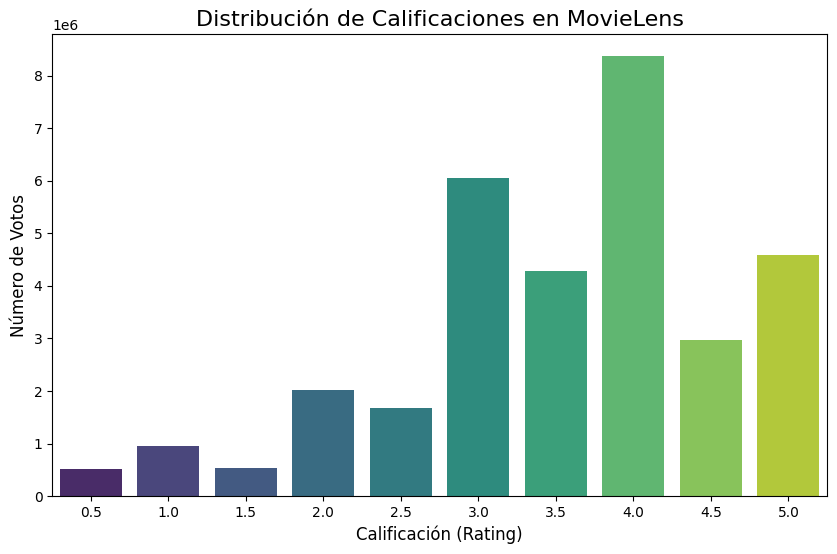

In [ ]:
# Calcular la distribución de ratings en Spark (como hicimos antes)
rating_distribution = ratings_df.groupBy("rating").count().orderBy("rating")

# Convertir el resultado a un DataFrame de Pandas
pandas_df = rating_distribution.toPandas()

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x="rating", y="count", data=pandas_df, palette="viridis")
plt.title("Distribución de Calificaciones en MovieLens", fontsize=16)
plt.xlabel("Calificación (Rating)", fontsize=12)
plt.ylabel("Número de Votos", fontsize=12)
plt.show()

## 6. Los Géneros de Películas Más Comunes
Ya calculamos la frecuencia de cada género, pero un gráfico de barras lo hará mucho más claro. Este gráfico nos mostrará qué géneros dominan el catálogo de películas.

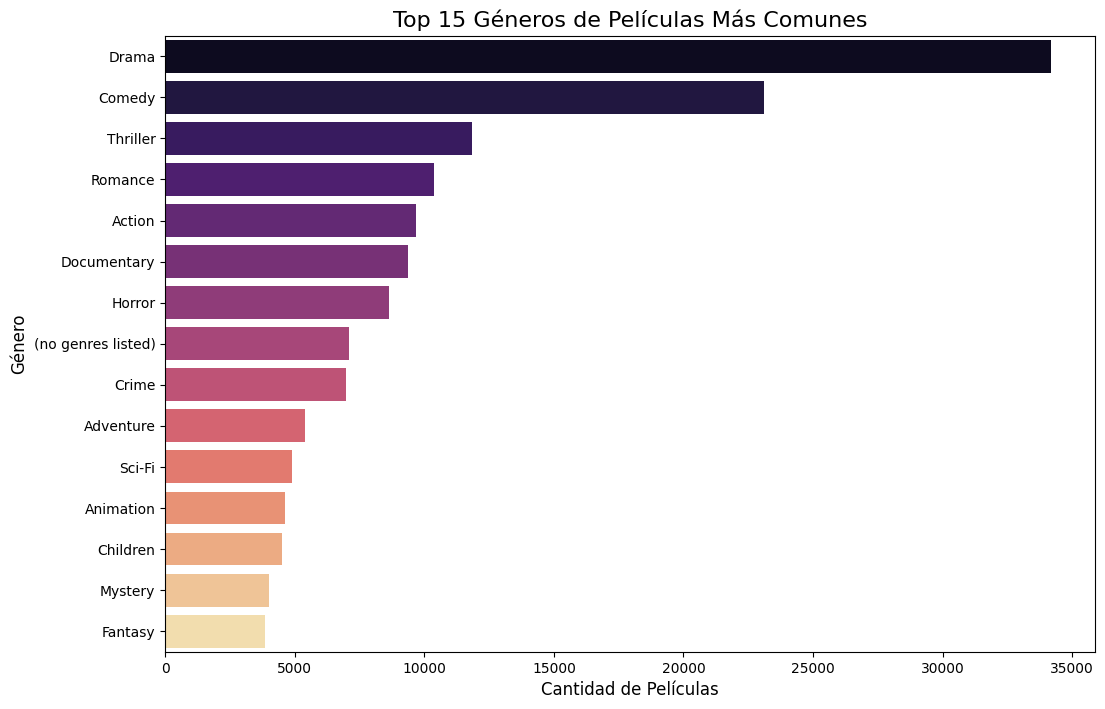

In [ ]:
# Preparar los datos de géneros en Spark (si no lo has hecho)
# Este código separa y cuenta los géneros.
genres_df = movies_df.withColumn("genre", explode(split(col("genres"), "\|")))
genre_counts = genres_df.groupBy("genre").count().orderBy(desc("count")).limit(15)

# Convertir a Pandas para graficar
pandas_genres_df = genre_counts.toPandas()

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x="count", y="genre", data=pandas_genres_df, orient='h', palette="magma")
plt.title("Top 15 Géneros de Películas Más Comunes", fontsize=16)
plt.xlabel("Cantidad de Películas", fontsize=12)
plt.ylabel("Género", fontsize=12)
plt.show()

## 7. Actividad de Calificaciones a lo Largo del Tiempo
El dataset tiene una columna timestamp que nos dice cuándo se hizo cada calificación. Podemos usarla para ver cómo ha crecido la actividad en la plataforma a lo largo de los años.

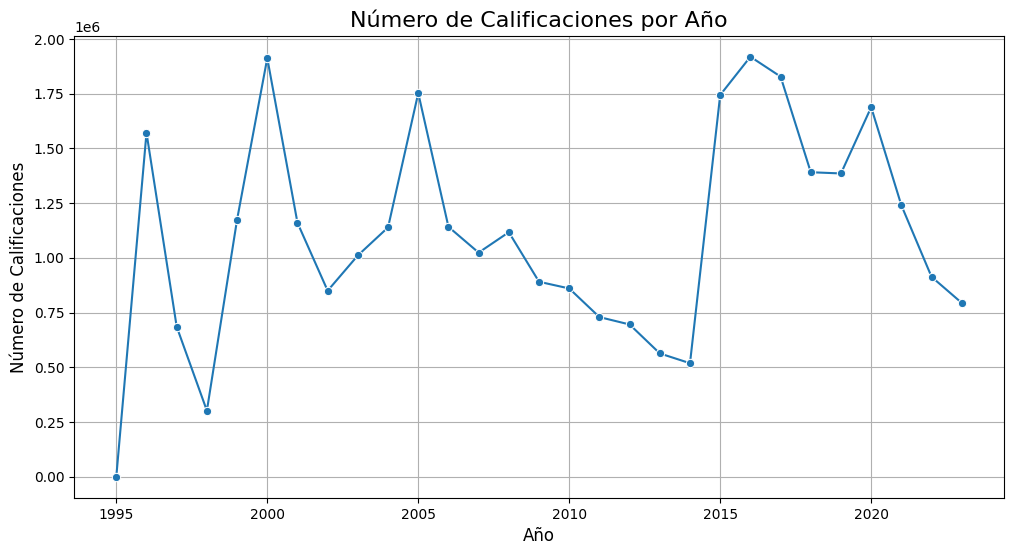

In [ ]:
# Extraer el año de la columna 'timestamp'
# from_unixtime convierte el número de timestamp a una fecha legible.
# year() extrae solo el año de esa fecha.
ratings_with_year_df = ratings_df.withColumn("year", year(from_unixtime(col("timestamp"))))

# Contar el número de calificaciones por año
ratings_per_year = ratings_with_year_df.groupBy("year").count().orderBy("year")

# Convertir a Pandas para graficar
pandas_yearly_df = ratings_per_year.toPandas()

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
sns.lineplot(x="year", y="count", data=pandas_yearly_df, marker='o')
plt.title("Número de Calificaciones por Año", fontsize=16)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Número de Calificaciones", fontsize=12)
plt.grid(True)
plt.show()

## Preparación de datos
Vamos a ejecutar el código para limpiar y dividir los datos. Esto asegura que partimos de un punto limpio y tenemos nuestros conjuntos de training_df y test_df listos, por si el entorno de Colab se reinició.

In [4]:
# Seleccionar las columnas necesarias, asegurar el tipo de dato y eliminar nulos
data_df = ratings_df.select(
    col("userId").cast(IntegerType()),
    col("movieId").cast(IntegerType()),
    col("rating").cast(FloatType())
).na.drop()

# Dividir los datos: 80% para entrenamiento y 20% para prueba
(training_df, test_df) = data_df.randomSplit([0.8, 0.2], seed=42)

# Guardar en caché para un acceso más rápido
training_df.cache()
test_df.cache()

print("Datos preparados y divididos en entrenamiento y prueba.")
print(f"Total de calificaciones para entrenamiento: {training_df.count():,}")
print(f"Total de calificaciones para prueba: {test_df.count():,}")

✅ Datos preparados y divididos en entrenamiento y prueba.
Total de calificaciones para entrenamiento: 25,600,204
Total de calificaciones para prueba: 6,400,000


### Entrenamiento de Modelo de Recomendación (ALS)
Importaremos el algoritmo ALS de la librería de Machine Learning de Spark (MLlib), configuraremos sus parámetros y lo entrenaremos con nuestros datos de training_df.

Parámetros clave:

`maxIter`: El número de veces que el algoritmo iterará sobre los datos para aprender los patrones.

`regParam`: Un parámetro de regularización para evitar que el modelo se "sobreajuste" a los datos de entrenamiento.

`coldStartStrategy`: Qué hacer si en los datos de prueba aparece un usuario o película que no estaba en los datos de entrenamiento. "drop" simplemente los ignorará.

In [7]:
# Configurar el algoritmo Alternating Least Squares (ALS)
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop", # Ignora usuarios/películas nuevos en la fase de prueba
    nonnegative=True          # Asegura que las predicciones no sean negativas
)

# Entrenar el modelo usando los datos de entrenamiento
print("⏳ Entrenando el modelo ALS... (esto puede tardar unos minutos)")

model = als.fit(training_df)

print("Modelo entrenado con éxito")

⏳ Entrenando el modelo ALS... (esto puede tardar unos minutos)
✅ ¡Modelo entrenado con éxito!


## Evaluación del Modelo
Usaremos una métrica estándar llamada Error Cuadrático Medio (RMSE). En pocas palabras, nos dice qué tan "lejos" están las predicciones del modelo de las calificaciones reales. Un valor de RMSE más bajo es mejor.

In [8]:
# Usar el modelo para hacer predicciones en el conjunto de prueba
print("Realizando predicciones en los datos de prueba...")
predictions = model.transform(test_df)

# Crear un evaluador para medir el error
# La métrica "rmse" calculará el Error Cuadrático Medio.
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",       # La columna con el valor real
    predictionCol="prediction" # La columna con la predicción del modelo
)

# Calcular el RMSE
print("Calculando el error del modelo (RMSE)...")
rmse = evaluator.evaluate(predictions)

print(f"Evaluación completa.")
print(f"Error Cuadrático Medio (RMSE) = {rmse:.4f}")

# (Opcional) Ver algunas de las predicciones
print("\nMuestra de las predicciones:")
predictions.select("userId", "movieId", "rating", "prediction").show(10)

📊 Realizando predicciones en los datos de prueba...
📉 Calculando el error del modelo (RMSE)...
✅ Evaluación completa.
Error Cuadrático Medio (RMSE) = 0.8109

🔍 Muestra de las predicciones:
+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|     29|   2.0| 3.7078803|
|     1|     36|   1.0| 3.2070594|
|     1|    110|   3.0| 2.7482285|
|     1|    223|   3.0| 3.3154163|
|     1|    322|   4.0| 3.1105444|
|     1|    541|   5.0| 3.9487705|
|     1|    835|   3.0| 2.7044356|
|     1|    916|   4.0| 3.6083488|
|     1|   1090|   5.0| 3.3050394|
|     1|   1094|   4.0| 3.4162283|
+------+-------+------+----------+
only showing top 10 rows



# Prubas al modelo

## Generar Recomendaciones de Películas
Vamos a pedirle al modelo las 10 mejores recomendaciones de películas para un usuario específico.

In [9]:
# Generar las 10 mejores recomendaciones para cada usuario
user_recommendations = model.recommendForAllUsers(10)

print("Top 10 recomendaciones para el usuario con ID 15:")
user_recommendations.filter(col("userId") == 15).show(truncate=False)

✨ Top 10 recomendaciones para el usuario con ID 15:
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                               |
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|15    |[{274047, 5.9899216}, {270306, 5.6303186}, {240070, 5.6303186}, {240054, 5.6303186}, {203882, 5.471368}, {289897, 5.3878274}, {205587, 5.380093}, {177209, 5.3379865}, {185211, 5.309669}, {231289, 5.302699}]|
+------+----------------------------------------------------------------------------

In [10]:
# Seleccionar las recomendaciones para un usuario (ej: userId = 15)
single_user_recs = user_recommendations.filter(col("userId") == 15)

# Usar "explode" para convertir la lista de recomendaciones en filas separadas
recommendations_df = single_user_recs.withColumn("rec", explode(col("recommendations"))) \
    .select(
        col("userId"),
        col("rec.movieId").alias("movieId"),
        col("rec.rating").alias("predicted_rating")
    )

# Unir con el dataframe de películas para obtener los títulos
recommendations_with_titles = recommendations_df.join(movies_df, "movieId")

print("\nTop 10 Películas Recomendadas para el Usuario 15 (con títulos):")
recommendations_with_titles.select("title", "predicted_rating").show(10, truncate=False)


🎬 Top 10 Películas Recomendadas para el Usuario 15 (con títulos):
+-------------------------------------------------------------------------+----------------+
|title                                                                    |predicted_rating|
+-------------------------------------------------------------------------+----------------+
|The Sound of Violet (2022)                                               |5.9899216       |
|WWE: The Triumph and Tragedy of World Class Championship Wrestling (2007)|5.6303186       |
|SpongeBob SquarePants: Heroes of Bikini Bottom (2011)                    |5.6303186       |
|SpongeBob SquarePants: Tide and Seek                                     |5.6303186       |
|Dead in the Water (2006)                                                 |5.471368        |
|O Canada! (1982)                                                         |5.3878274       |
|678 (2010)                                                               |5.380093        |
|Ac

## Encontrar Películas Similares (el efecto "Más como esto" de Netflix)
El modelo no solo aprendió sobre los usuarios, sino que también aprendió el "ADN" de cada película (sus factores latentes). Podemos usar este conocimiento para encontrar las películas más similares a una en particular.

La idea es tomar el "ADN" (el vector de factores) de una película y buscar otras películas con un ADN parecido.

In [14]:
def find_similar_movies(movie_title, top_n=10):
    """
    Encuentra las 'top_n' películas más similares a una película dada.
    """
    try:
        # Obtener el ID y los factores de la película de entrada
        movie_row = movies_df.filter(col("title") == movie_title).first()
        movie_id = movie_row["movieId"]

        # Obtenemos los factores de la película específica
        movie_features_row = model.itemFactors.filter(col("id") == movie_id).first()

        # Convertimos la lista de features a un objeto DenseVector
        movie_factors = Vectors.dense(movie_features_row["features"])

        # Calcular la similitud del coseno entre esta película y todas las demás
        similarities = model.itemFactors.rdd.map(
            lambda row: (row.id, float(movie_factors.dot(row.features) / (movie_factors.norm(2) * Vectors.dense(row.features).norm(2))))
        ).toDF(["movieId", "similarity"])

        # Unir con los títulos y mostrar las más similares
        similar_movies = similarities.join(movies_df, "movieId") \
            .orderBy(desc("similarity")) \
            .filter(col("title") != movie_title) \
            .limit(top_n)

        print(f"Películas más similares a '{movie_title}':")
        similar_movies.select("title", "similarity").show(truncate=False)

    except (TypeError, AttributeError):
        print(f"No se pudo encontrar la película '{movie_title}'. Intenta con otro título.")

# Prueba
find_similar_movies("Toy Story (1995)")
find_similar_movies("Matrix, The (1999)")

🎬 Películas más similares a 'Toy Story (1995)':
+------------------------------------+------------------+
|title                               |similarity        |
+------------------------------------+------------------+
|Toy Story 2 (1999)                  |0.9979460186835156|
|Toy Story 3 (2010)                  |0.9926023303753191|
|A Love Song (2022)                  |0.990018401291524 |
|The Chinese Ring (1947)             |0.9887987444706439|
|Three Lives of Thomasina, The (1964)|0.9887547744628334|
|Incredibles, The (2004)             |0.9886428659212848|
|The Bulleteers (1942)               |0.9880249582646299|
|Jungle Book, The (1967)             |0.9877866921924049|
|Bug's Life, A (1998)                |0.9872985060498816|
|Bad Reputation (2018)               |0.9853300621552701|
+------------------------------------+------------------+

🎬 Películas más similares a 'Matrix, The (1999)':
+-----------------------------------+------------------+
|title                          